In [ ]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle (2).json


{'kaggle (2).json': b'{"username":"dinaabdallahshalaby","key":"534b671d4cab9857389e32867f2944d1"}'}

In [ ]:
!pip install kaggle

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d dagnelies/deepfake-faces
!unzip -q deepfake-faces.zip -d deepfake_faces


Dataset URL: https://www.kaggle.com/datasets/dagnelies/deepfake-faces
License(s): other
deepfake-faces.zip: Skipping, found more recently modified local copy (use --force to force download)
replace deepfake_faces/faces_224/aaagqkcdis.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import pandas as pd
import os


data_dir = "deepfake_faces"
metadata_path = os.path.join(data_dir, "metadata.csv")

df = pd.read_csv(metadata_path)
print(df.head())
print(df['label'].value_counts())


        videoname  original_width  original_height label        original
0  aznyksihgl.mp4             129              129  FAKE  xnojggkrxt.mp4
1  gkwmalrvcj.mp4             129              129  FAKE  hqqmtxvbjj.mp4
2  lxnqzocgaq.mp4             223              217  FAKE  xjzkfqddyk.mp4
3  itsbtrrelv.mp4             186              186  FAKE  kqvepwqxfe.mp4
4  ddvgrczjno.mp4             155              155  FAKE  pluadmqqta.mp4
label
FAKE    79341
REAL    16293
Name: count, dtype: int64


In [ ]:
df['filepath'] = df['videoname'].apply(lambda x: os.path.join(data_dir, "faces_224", x.replace('.mp4','.jpg')))
print(df[['videoname', 'filepath', 'label']].head())


        videoname                                 filepath label
0  aznyksihgl.mp4  deepfake_faces/faces_224/aznyksihgl.jpg  FAKE
1  gkwmalrvcj.mp4  deepfake_faces/faces_224/gkwmalrvcj.jpg  FAKE
2  lxnqzocgaq.mp4  deepfake_faces/faces_224/lxnqzocgaq.jpg  FAKE
3  itsbtrrelv.mp4  deepfake_faces/faces_224/itsbtrrelv.jpg  FAKE
4  ddvgrczjno.mp4  deepfake_faces/faces_224/ddvgrczjno.jpg  FAKE


In [ ]:
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

print(len(train_df), len(valid_df), len(test_df))



66943 14345 14346


In [ ]:
import tensorflow as tf

label_map = {'REAL': 0, 'FAKE': 1}

def preprocess(fp, label):
    image = tf.io.read_file(fp)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_ds = tf.data.Dataset.from_tensor_slices((
    train_df['filepath'].values,
    train_df['label'].map(label_map).values
))
train_ds = train_ds.map(preprocess).shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((
    valid_df['filepath'].values,
    valid_df['label'].map(label_map).values
)).map(preprocess).batch(32)

test_ds = tf.data.Dataset.from_tensor_slices((
    test_df['filepath'].values,
    test_df['label'].map(label_map).values
)).map(preprocess).batch(32)


In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])


In [ ]:
for images, labels in train_ds.take(1):
    print(images.shape, labels.numpy())


(32, 224, 224, 3) [1 1 1 1 1 1 0 0 1 1 1 0 1 1 1 0 1 1 1 0 1 1 0 1 1 1 1 1 1 1 0 1]


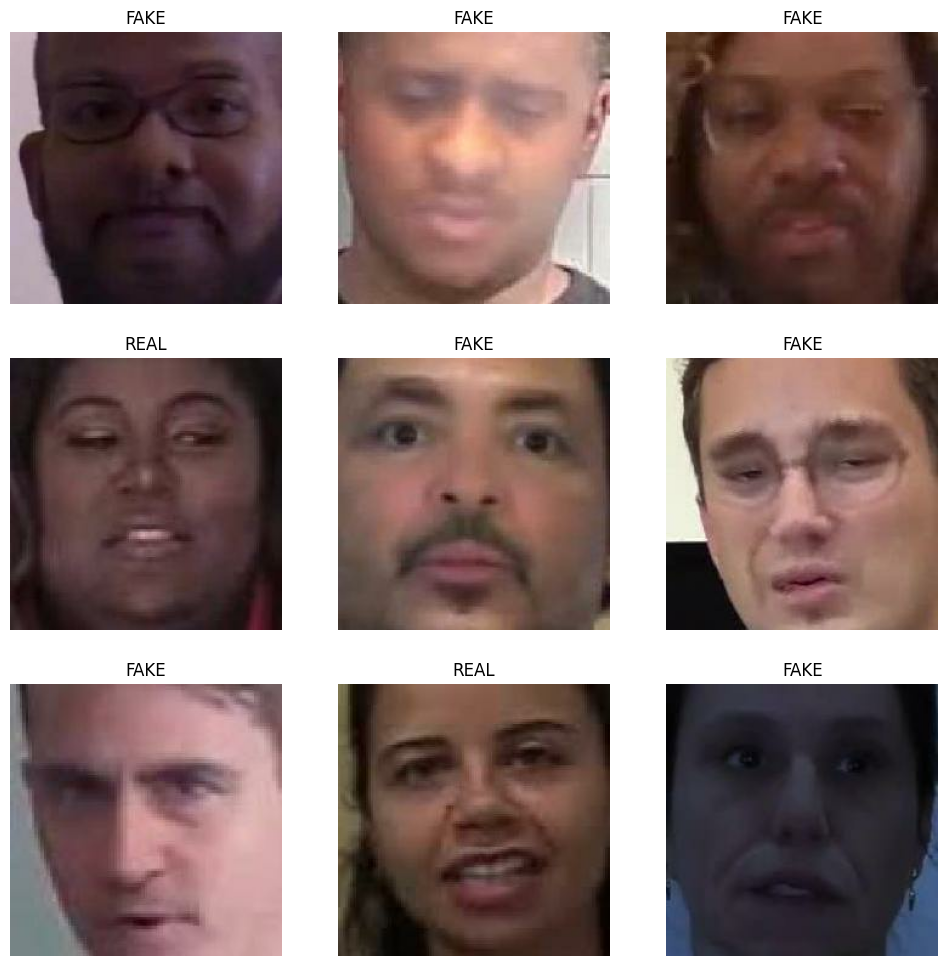

In [ ]:
import matplotlib.pyplot as plt

for images, labels in train_ds.take(1):
    plt.figure(figsize=(12, 12))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        label_text = "REAL" if labels[i].numpy() == 0 else "FAKE"
        plt.title(label_text)
        plt.axis("off")
    plt.show()


In [ ]:
def classify_features(df):
    categorical_features = []
    non_categorical_features = []
    discrete_features = []
    continuous_features = []

    for column in df.columns:
        if df[column].dtype == 'object':
            if df[column].nunique() < 10:
                categorical_features.append(column)
            else:
                non_categorical_features.append(column)
        elif df[column].dtype in ['int64', 'float64']:
            if df[column].nunique() < 10:
                discrete_features.append(column)
            else:
                continuous_features.append(column)

    return categorical_features, non_categorical_features, discrete_features, continuous_features


In [ ]:
categorical, non_categorical, discrete, continuous = classify_features(df)
print("Categorical Features:", categorical)
print("Non-Categorical Features:", non_categorical)
print("Discrete Features:", discrete)
print("Continuous Features:", continuous)

Categorical Features: ['label']
Non-Categorical Features: ['videoname', 'original', 'filepath']
Discrete Features: []
Continuous Features: ['original_width', 'original_height']


In [ ]:
df.isna().sum()


,0
videoname,0
original_width,0
original_height,0
label,0
original,16293
filepath,0


In [ ]:
df = df.fillna("Not Available")

In [ ]:
for i in categorical:
    print(i,':', df[i].unique())
    print()
for i in categorical:
    print(df[i].value_counts())
    print()

label : ['FAKE' 'REAL']

label
FAKE    79341
REAL    16293
Name: count, dtype: int64



/tmp/ipython-input-966177833.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = df[i], data = df, palette = 'hls')


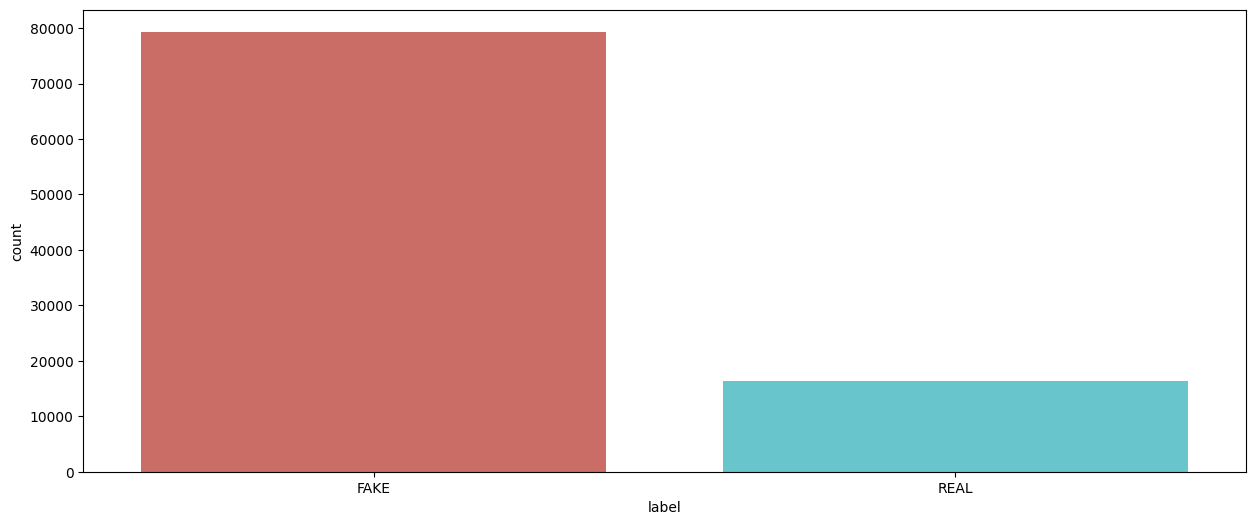

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
for i in categorical:
    plt.figure(figsize=(15,6))
    sns.countplot(x = df[i], data = df, palette = 'hls')
    plt.show()

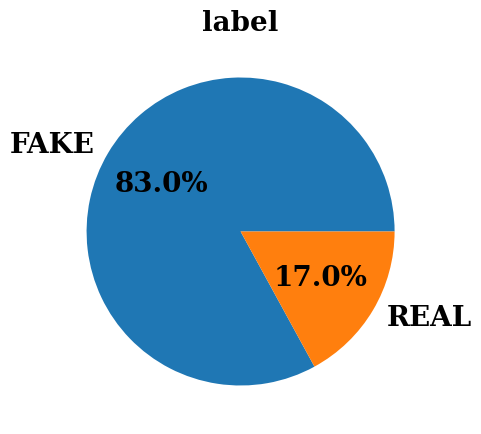

In [ ]:
for i in categorical:
    plt.figure(figsize=(5,5))
    plt.pie(df[i].value_counts(), labels=df[i].value_counts().index,
            autopct='%1.1f%%', textprops={ 'fontsize': 20,
                                           'color': 'black',
                                           'weight': 'bold',
                                           'family': 'serif' })
    hfont = {'fontname':'serif', 'weight': 'bold'}
    plt.title(i, size=20, **hfont)
    plt.show()